In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
from iminuit import Minuit
from scipy import stats
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/Lund/'

SMPS = read_SMPS(path, parent_path, [0, 0])
OPS_APS = read_OPS(path, parent_path, 0)

NS_dict_keys = ['2024-10-15_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan']
NS_bins = SMPS['2024-10-21_NanoScan'].keys()[3:16].to_list()

NS_bg_mean, NS_bg_std, NS_bg_error = bin_mean(['2024/10/21 11:45:00', '2024/10/21 14:10:00'], 
                                              SMPS['2024-10-21_NanoScan'], NS_bins, 'Time', 0.1)

for key in NS_dict_keys:
    df = SMPS[key]
    for i, bin in enumerate(NS_bins):
        df[bin] = df[bin] - NS_bg_mean[i]

    SMPS[key] = df

dict_keys = ['Exp1', 'Exp2', 'Exp3', 'Exp4']
OPS_mid_point = [0.337, 0.419, 0.522, 0.650, 0.809, 1.007, 1.254, 1.562, 1.944, 2.421, 3.014, 3.752, 4.672, 5.816, 7.241, 9.015]
OPS_bins = OPS_APS['Exp1'].keys()[1:17].to_list()

for dict_key in dict_keys:
    for old_key, new_key in zip(OPS_bins, OPS_mid_point):
        OPS_APS[dict_key] = OPS_APS[dict_key].rename(columns = {old_key: new_key})

OPS_cut_point = [0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]

NS_OPS_cut = [0.010, 0.0132, 0.0179, 0.0234, 0.032, 0.0416, 0.057, 0.0739, 0.1015, 0.1314, 0.1805, 0.2337, 
              0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]

time_wBG = [['2024-10-16 09:50:00', '2024-10-16 12:50:00'],
            ['2024-10-16 14:30:00', '2024-10-16 16:30:00'],
            ['2024-10-17 09:30:00', '2024-10-17 12:10:00'],
            ['2024-10-17 14:10:00', '2024-10-17 15:30:00']]

timestamps_exp = [['2024-10-16 10:45:00', '2024-10-16 12:26:00'],
                  ['2024-10-16 15:00:00', '2024-10-16 15:34:00'],
                  ['2024-10-17 10:20:00', '2024-10-17 12:00:00'],
                  ['2024-10-17 14:30:00', '2024-10-17 15:00:00']]

NanoScan_dict_keys = ['2024-10-16_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan', '2024-10-17_NanoScan']
NS_OPS_number, NS_OPS_mass, NS_OPS_keys, NS_OPS_bin_mean = merge_data(SMPS, NanoScan_dict_keys, [3, 15], OPS_APS, dict_keys, [1, 17], time_wBG, ['Time', 'Time'], False, True)

Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,


In [3]:
def Chi2_fit(x, y, yerr, fitfunc, **kwargs):
    # Written by Philip Kofoed-Djursner
    # Unbinned log likelihood fitter
    
    def obt(*args):
        chi2 = np.sum(((y-fitfunc(x, *args))/yerr)**2)
        return chi2

    minuit = Minuit(obt, **kwargs, name = [*kwargs]) # Setup; obtimization function, initial variable guesses, names of variables. 
    minuit.errordef = 1 # needed for likelihood fits. No explaination in the documentation.

    minuit.migrad() # Compute the fit
    valuesfit = np.array(minuit.values, dtype = np.float64) # Convert to numpy
    errorsfit = np.array(minuit.errors, dtype = np.float64) # Convert to numpy
    if not minuit.valid: # Give custom error if the fit did not converge
        print("!!! Fit did not converge !!!\n!!! Give better initial parameters !!!")

    Nvar = len(kwargs)           # Number of variables
    Ndof_fit = len(x) - Nvar

    Chi2_fit = minuit.fval                          # The chi2 value
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit) 

    return valuesfit, errorsfit, Prob_fit

In [4]:

def plot_fitted_mean(ax, timestamps, df, df_keys, timelabel, inst_error, bin_means, bin_edges, cut_point, fitfunc, colors, initial_guess):

    mean, std, error = bin_mean(timestamps, df, df_keys, timelabel, inst_error)

    if bin_edges != None:
        dlogDp = np.log10(bin_edges[1:])-np.log10(bin_edges[:-1])
        mean = mean/dlogDp
        std=std/dlogDp
        error=error/dlogDp

    abs_error = [abs(error) for error in error]

    if cut_point == None:
        ax.errorbar(bin_means, mean, abs_error, ecolor='k', elinewidth=0.5, capsize=2, capthick=0.5, color=colors[0], lw = 1.2)
    else:
        df_mean = pd.DataFrame({'Bin mean': bin_means, 'Concentration': mean, 'Error': abs_error})
        
        lower_cut = df_mean['Bin mean'] < cut_point
        upper_cut = df_mean['Bin mean'] > cut_point

        ax.errorbar(df_mean['Bin mean'][lower_cut], df_mean['Concentration'][lower_cut], df_mean['Error'][lower_cut], ecolor='k', elinewidth=0.5, capsize=2, capthick=0.5, color=colors[0], lw = 1.2)
        ax.errorbar(df_mean['Bin mean'][upper_cut], df_mean['Concentration'][upper_cut], df_mean['Error'][upper_cut], ecolor='k', elinewidth=0.5, capsize=2, capthick=0.5, color=colors[0], lw = 1.2)

    bin_mean_fit = np.linspace(min(bin_means), max(bin_means), 1000)

    fit_params, fit_errors, Prob = Chi2_fit(bin_means, mean, error, fitfunc, **initial_guess)
    ax.plot(bin_mean_fit, fitfunc(bin_mean_fit, *fit_params[:]), color = colors[1], ls = '--', lw = 1)

    print(fit_params)
    print(Prob)

    return ax, fit_params, fit_errors, df_mean

[64.51107692  0.14279873  0.67299396 39.12596807  0.9094428   0.8187386 ]
1.5138469578438242e-14


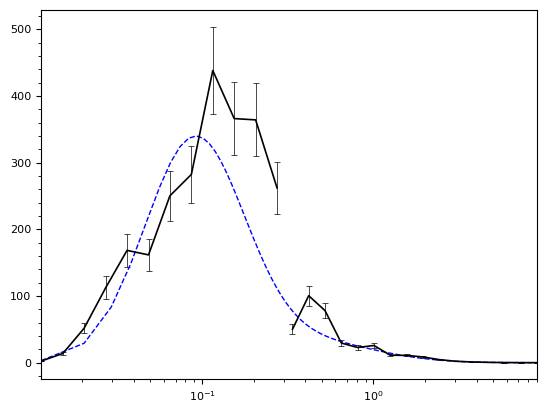

In [5]:
initial_guess = {
    'p1': 64, 
    'mu1': 0.14, 
    'sigma1': 0.67, 
    'p2': 39, 
    'mu2': 0.91,
    'sigma2': 0.82}
fig, ax = plt.subplots()

ax, fit_params, fit_errors, df_mean = plot_fitted_mean(ax, timestamps_exp[0], NS_OPS_number['Exp1'], NS_OPS_keys, 'Time', 0.15, 
                                                       NS_OPS_bin_mean, NS_OPS_cut, 0.3, d_loggauss, ['k', 'b'], 
                                                       initial_guess)

ax.set_xscale('log')

[8.17581420e+00 4.90674309e-02 4.33958338e-01 4.71028815e+01
 7.63488499e-01 8.75532635e-01 6.19891275e+01 1.54486195e-01
 4.06700018e-01]
1.5873049875391454e-07


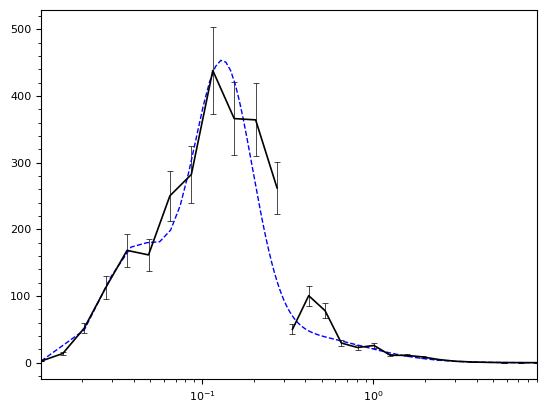

In [6]:
initial_guess = {
    'p1': 64,  
    'mu1': 0.14, 
    'sigma1': 0.67, 
    'p2': 39,
    'mu2': 0.91,
    'sigma2': 0.82,
    'p3': 30,
    'mu3': 0.3,
    'sigma3': 0.5}
fig, ax = plt.subplots()

ax, fit_params, fit_errors, df_mean = plot_fitted_mean(ax, timestamps_exp[0], NS_OPS_number['Exp1'], NS_OPS_keys, 'Time', 0.15, 
                                                       NS_OPS_bin_mean, NS_OPS_cut, 0.3, t_loggauss, ['k', 'b'], 
                                                       initial_guess)

ax.set_xscale('log')